## Assignment 2 - Image Classification
In this assignment, you will practice on image classification using CIFAR-10 dataset.
The codes for data downloading and processing are provided below. Note the train dataset is further split into train_ds and val_ds and three dataloaders (i.e., train_loader, val_loader, and test_loader) are created for training, validation, and testing, respectively.

You will need to complete the following tasks:

(1) Code the MnasNet-A1 (shown below, ref: https://arxiv.org/abs/1807.11626) in PyTorch by following the similar coding style as the examples shown in "NB6_ModernCNNs.ipynb". Specifically, you will need to "modularize" your codes, i.e., define proper "classes" and/or "functions" for different blocks as shown in Figure 7 below (e.g., MBConv3, MBConv6, and SepConv) and then use them to construct your model architecture.

(2) Train the MnasNet-A1 using CIFAR-10.

(3) Evaluate your model and report performance on the test dataset.


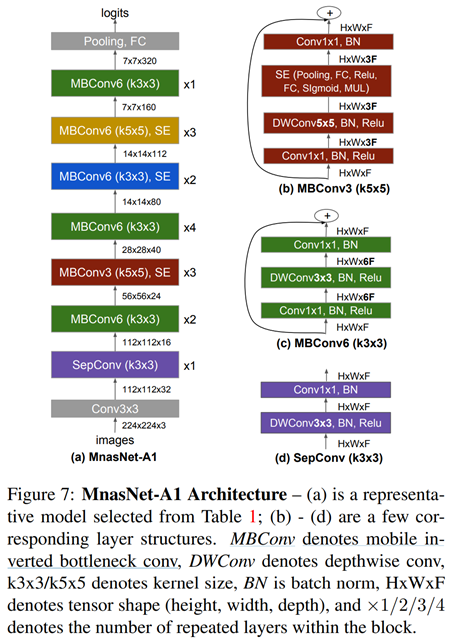

### Download datasets and create dataloaders

In [ ]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.nn import functional as F
from torch import nn
from sklearn.metrics import confusion_matrix
import numpy as np
import d2l
from d2l import torch as d2l
import math
from torchvision.utils import make_grid
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

test_cf10_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_cf10_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    normalize
])



train = CIFAR10(root='./data', train=True, download=True, transform=train_cf10_transforms)
test = CIFAR10(root='./data', train=False, download=True, transform=test_cf10_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
torch.manual_seed(42)
val_size = 5000
train_size = len(train) - val_size

In [ ]:
train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=2048

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([2048, 3, 32, 32])


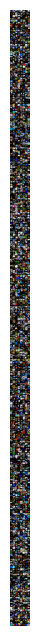

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## Your codes go here:
### (1) Define the model

In [ ]:
class DepthWiseSeperableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, bias=False, padding = 0):
        super(DepthWiseSeperableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1,
                               groups=in_channels, bias=bias, padding = padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, stride=1,
                               kernel_size=1, bias=bias, padding = padding)
        self._initialize_weights()
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)

In [ ]:
class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)

In [ ]:
class SepConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 1, padding=0):
        super(SepConv, self).__init__()
        self.p1 = nn.Conv2d(in_channels, out_channels,kernel_size=1, padding=padding)
        self.p2 = nn.BatchNorm2d(out_channels)
        self.p3 = DepthWiseSeperableConv2d(in_channels,in_channels, 3)
        self.p4 = nn.BatchNorm2d(in_channels)
        self._initialize_weights()
    def forward(self, X):
        return self.p2(self.p1(F.relu(self.p4(self.p3(X)))))

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)


In [ ]:
class MBConv6(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, padding = 0, use_1x1conv=False):
        super(MBConv6, self).__init__()
        self.p1 = nn.Conv2d(in_channels, 6*in_channels,stride = 1, kernel_size=1, padding = 1)
        self.p2 = nn.BatchNorm2d(6*in_channels)
        self.p3 = DepthWiseSeperableConv2d(6*in_channels,6*in_channels, 3, stride = stride)
        self.p4 = nn.BatchNorm2d(6*in_channels)
        self.p5 = nn.Conv2d(6*in_channels, out_channels,stride = stride, kernel_size=1)
        self.p6 = nn.BatchNorm2d(out_channels)
        if(use_1x1conv):
            self.conv = nn.Conv2d(in_channels, out_channels,stride = stride, kernel_size=1)
        else:
            self.conv = None
        self._initialize_weights()
    def forward(self, X):
        first = F.relu(self.p2(self.p1(X)))
        second = F.relu(self.p4(self.p3(first)))
        third = self.p6(self.p5(second))
        if self.conv:
            X = self.conv(X)
        third += X
        return third
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)

In [ ]:
class MBConv3(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, padding=0, use_1x1conv=False):
        super(MBConv3, self).__init__()
        self.p1 = nn.Conv2d(in_channels, 3*in_channels, stride = stride, kernel_size=1)
        self.p2 = nn.BatchNorm2d(3*in_channels)
        self.p3 = DepthWiseSeperableConv2d(3*in_channels, 3*in_channels, 5, padding = 1)
        self.p4 = nn.BatchNorm2d(3*in_channels)
        self.p5 = SE_Block(3*in_channels)
        self.p6 = nn.Conv2d(3*in_channels, out_channels, kernel_size=1)
        self.p7 = nn.BatchNorm2d(out_channels)
        if(use_1x1conv):
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=stride)
        else:
            self.conv = None
        self._initialize_weights()
    def forward(self, X):
        first = F.relu(self.p2(self.p1(X)))
        second = F.relu(self.p4(self.p3(first)))
        third = self.p7(self.p6(self.p5(second)))
        if self.conv:
            X = self.conv(X)
        third += X
        return third
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)

In [ ]:
def make_MNasNetA1():
    conv3x3 = nn.Conv2d(3,32,kernel_size=3, stride = 2, padding=1)
    sepconv1 = SepConv(32, 16, padding = 1)
    mbconv62 = nn.Sequential(MBConv6(16,24, stride = 2, padding = 1, use_1x1conv=True), MBConv6(24,24, use_1x1conv=False))
    mbconv3se3 = nn.Sequential(MBConv3(24,40, padding =1 ,stride = 2, use_1x1conv=True), SE_Block(40), MBConv3(40,40), SE_Block(40,40), MBConv3(40,40,use_1x1conv=False), SE_Block(40))
    mbconv64 = nn.Sequential(MBConv6(40,80, stride = 2, padding = 1,use_1x1conv=True),MBConv6(80,80),MBConv6(80,80),MBConv6(80,80))
    mbconv6se2 = nn.Sequential(MBConv6(80,112, padding=1, use_1x1conv=True), SE_Block(112), MBConv6(112,112), SE_Block(112))
    mbconv6se3 = nn.Sequential(MBConv6(112,160, padding=1, stride =2, use_1x1conv=True), SE_Block(160), MBConv6(160,160), SE_Block(160), MBConv6(160,160), SE_Block(160))
    mbconv6 = MBConv6(160,320, padding=1, use_1x1conv=True)
    poolingFC = nn.Sequential(nn.Conv2d(320, 1280,kernel_size=1, stride=1),
                              nn.BatchNorm2d(1280), nn.ReLU(inplace=True),
                              nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Dropout(p=.3), nn.Linear(1280, 10))
    net = nn.Sequential(conv3x3, sepconv1, mbconv62, mbconv3se3, mbconv64, mbconv6se2, mbconv6se3, mbconv6, poolingFC)
    return net

In [ ]:
def initialize_weights(net):
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)

In [ ]:
X = torch.rand(size=(1,3, 224, 224))
#test layers on input from paper
net = make_MNasNetA1()
initialize_weights(net)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 32, 112, 112])
SepConv output shape:	 torch.Size([1, 16, 112, 112])
Sequential output shape:	 torch.Size([1, 24, 56, 56])
Sequential output shape:	 torch.Size([1, 40, 28, 28])
Sequential output shape:	 torch.Size([1, 80, 14, 14])
Sequential output shape:	 torch.Size([1, 112, 14, 14])
Sequential output shape:	 torch.Size([1, 160, 7, 7])
MBConv6 output shape:	 torch.Size([1, 320, 7, 7])
Sequential output shape:	 torch.Size([1, 10])


### (2) Train the model using train and val datasets

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, scheduler, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    #This is from d2l
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())

    if (scheduler):
        loss = nn.CrossEntropyLoss()
        output = loss(net(X), y)
        #print(output)
        scheduler.step(output)
    return metric[0] / metric[1]

In [ ]:
lr = .01
num_epochs = 300
#This is from d2l and NB6
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter, scheduler)

        animator.add(epoch + 1, (None, None, test_acc))
    print("LR: ", optimizer.param_groups[0]['lr'])
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'val acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

LR:  1.0000000000000004e-08
loss 0.396, train acc 0.862, val acc 0.818
12447.8 examples/sec on cuda:0


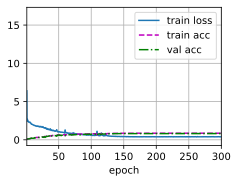

In [ ]:
train_ch6(net, train_loader, val_loader, num_epochs, lr, d2l.try_gpu())

### (3) Evaluate the model and report performance using the test dataset

In [ ]:
evaluate_accuracy_gpu(net, test_loader, scheduler = None)

0.8251

In [ ]:
# prepare to count predictions for each class
#I thinkg I got this from pytorch or some online resource
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
predlist=torch.zeros(0,dtype=torch.long, device='cuda')
lbllist=torch.zeros(0,dtype=torch.long, device='cuda')
# again no gradients needed
with torch.no_grad():
    net.to(device)
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        predlist=torch.cat([predlist,predictions.view(-1).to(device)])
        lbllist=torch.cat([lbllist,labels.view(-1).to(device)])
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Confusion matrix
conf_mat=confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy())
print("Confusion Matrix")
print(conf_mat)

Accuracy for class: plane is 86.5 %
Accuracy for class: car   is 91.0 %
Accuracy for class: bird  is 75.6 %
Accuracy for class: cat   is 66.0 %
Accuracy for class: deer  is 81.4 %
Accuracy for class: dog   is 71.2 %
Accuracy for class: frog  is 87.5 %
Accuracy for class: horse is 85.2 %
Accuracy for class: ship  is 91.3 %
Accuracy for class: truck is 89.4 %
Confusion Matrix
[[865  13  34  12  10   0   6   6  39  15]
 [ 11 910   2   3   0   2   6   1  18  47]
 [ 50   3 756  38  57  30  44  14   6   2]
 [ 12   3  50 660  46 136  42  30  11  10]
 [  9   1  56  34 814  15  32  34   4   1]
 [  6   2  23 170  37 712  12  34   0   4]
 [  3   3  43  41  17  10 875   3   2   3]
 [ 15   1  17  37  38  33   0 852   2   5]
 [ 35  14   2  11   3   0   5   3 913  14]
 [ 31  42   1  11   0   0   4   5  12 894]]


<AxesSubplot:>

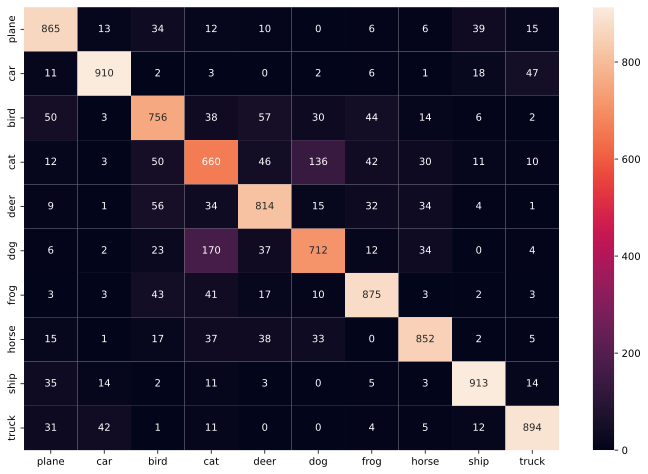

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']],
                  columns = [i for i in ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,fmt='g')